In [1]:
from __future__ import division
import numpy as np
from acoustics.signal import EqualBand, OctaveBand, Signal, Spectrum
from acoustics.generator import Generator
from acoustics.building_acoustics_measurement import BuildingAcousticsMeasurement

import matplotlib.pyplot as plt

DEBUG = True

In [5]:
class Test(object):
    def __init__(self, fs=44100, duration=10.0, n_channels=1, f_start=50., f_stop=5000., fraction=3, signal=None, response=None, noise_type='pink', state=None):
        if signal is not None:
            # ToDo: Case where a signal is given
            pass
        if response is not None:
            # Case where the measured response is given
            pass
        self._fs = fs
        self._f_start = f_start
        self._f_stop = f_stop
        self._fraction = fraction
        
        self.gen = Generator(fs, duration, state) #generate n_channels dimension signal
        if noise_type == 'sine_sweep':
            self.signal, reverse_signal = self.gen.noise(noise_type, [50., 5000.])
        else:
            self.signal = self.gen.noise(noise_type)
        self.signal = self.signal[None, ...]
        self.building_acoustics = BuildingAcousticsMeasurement(f_start=f_start, f_stop=f_stop, fraction=3)
        
        
        if DEBUG:
            print("Sample length : {0}").format(self.signal.shape[-1])
            
    
    def simulate_measured_signal(self):
        pass
    
    def filter_octaves(self):
        """
        Bandpass filter the test signal for each octave band.
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        The considered frequency range is inclusive of f_start and f_stop.
        Return the center frequencies of the octave bands
        and filtered signals for each octave band, and for each input channel.
        """
        signal_processor = Signal()
        frequencies = OctaveBand(fstart=self._f_start, fstop=self._f_stop, fraction=self._fraction)
        _, filtered_signal = signal_processor.bandpass_fractional_octaves(self.signal, self._fs, frequencies)
        
        return frequencies.center, filtered_signal
    
    
    def octave_spectrum(self):
        """
        Compute the power level of each octave band.
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        The considered frequency range is inclusive of f_start and f_stop.
        Return the center frequencies of the octave bands and their respective power level
        """
        spectrum = Spectrum()
        frequencies = OctaveBand(fstart=self._f_start, fstop=self._f_stop, fraction=self._fraction)
        _, ocataves_power_levels = spectrum.third_octaves(self.signal, self._fs, frequencies=frequencies.center)
        
        return frequencies.center, ocataves_power_levels
    
    
    def spl_computation(self):
        """
        Simulate measured sound int the transmitting and receiving room, and compute their respective SPL
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        Return the calculated SPL in the transmitting and the receiving room.
        """   
        # Simulate measured signal
        tx_room_attenuation = 0.9
        tx_room_noise_rms = 0.01
        tx_room_response_signal = self.gen.simulate_measured_signal(self.signal,  attenuation=tx_room_attenuation, noise_rms=tx_room_noise_rms)

        rx_room_attenuation = 0.1
        rx_room_noise_rms = 0.03
        rx_room_response_signal = self.gen.simulate_measured_signal(self.signal,  attenuation=rx_room_attenuation, noise_rms=rx_room_noise_rms)
        
        # Compute rooms' SPL
        
        self.building_acoustics.compute_spl('tx', tx_room_response_signal)
        self.building_acoustics.compute_spl('rx', rx_room_response_signal)
        tx_room_spl = self.building_acoustics.tx_room_spl
        rx_room_spl = self.building_acoustics.rx_room_spl
        
        return tx_room_spl, rx_room_spl
        
    def transmission_loss_computation(self):
        # Measure SPL in transmitting and receiving rooms
        tx_room_spl, rx_room_spl = self.spl_computation()
        
        # Compute tranmission loss
        self.building_acoustics.compute_transmission_loss()
        
        return self.building_acoustics.transmission_loss
    
    def rw_curve(self, f_start=100., f_stop=3150.):       
        # Measure SPL in transmitting and receiving rooms, and compute the transmission loss
        transmission_loss = self.transmission_loss_computation()
        
        # Compute tranmission loss
        self.building_acoustics.rw_curve()
        
        return self.building_acoustics.ref_curve
    
    def reverberation_time(self, signal, fs, method):
        self.building_acoustics.compute_reverberation_time('rx', signal, fs, method)
        return self.building_acoustics.reverberation_time

In [6]:
def main():
    fs = 44100
    duration = 10
    f_start=100.
    f_stop=3150.
    fraction = 3
    noise_type='sine_sweep'
    
    test = Test(noise_type=noise_type, f_start=f_start, f_stop=f_stop, fraction=fraction)
    
    octave_bands, filtered_signal = test.filter_octaves()
    octave_bands, octaves_power_levels = test.octave_spectrum()
    tx_room_spl, rx_room_spl = test.spl_computation()
    transmission_loss = test.transmission_loss_computation()
    ref_curve = test.rw_curve()
    
    # Test reverberation time calculation
    import wavio
    ir_file = '../../data/ir1_-_iringresso_new.wav'
    ir = wavio.read(ir_file)
    ir_data = ir.data[0:, 0]
    ir_fs = ir.rate
    reverberation_time = test.reverberation_time(ir_data, ir_fs, 'impulse')
    
    if DEBUG:
        print("Octave bands : {0} . Range {1}Hz to {2}Hz.\
               \nFiltered signal : (octaves,n_channels,sequence_length) : {3}")\
              .format(octave_bands.size, octave_bands[0], octave_bands[-1], filtered_signal.shape)
        
        test_channel = 0
        
        test_band = 0
        test_duration = 2
        T = fs * test_duration
        t = np.arange(T) / fs
        
        plt.title('Test signal. {0} seconds window.'.format(test_duration))
        plt.plot(t, test.signal[test_channel, :T])
        plt.show()
        
        plt.title('1/{0} octave filtered signal, for center freq={1}'\
                  .format(fraction, octave_bands[test_band]))
        plt.plot(t, filtered_signal[test_band, test_channel, :T])
        plt.show()
        
        plt.title('1/{0} octave power spectrum'.format(fraction))
        plt.plot(octave_bands, octaves_power_levels[test_channel])
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, tx_room_spl[test_channel, ...])
        plt.title('Transmitting room SPL spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, rx_room_spl[test_channel, ...])
        plt.title('Receiving room SPL spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, transmission_loss[test_channel, ...])
        plt.title('Tranmission loss spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, ref_curve[test_channel, ...])
        plt.plot(octave_bands, transmission_loss[test_channel, ...])
        plt.title('Rw curve vs Transmission loss spectrums')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, reverberation_time)
        plt.title('Reverberation time')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Reverberation Time [sec]')
        plt.grid()
        plt.show()

Sample length : 441000
Octave bands : 16 . Range 100.0Hz to 3162.27766017Hz.               
Filtered signal : (octaves,n_channels,sequence_length) : (16L, 1L, 441000L)


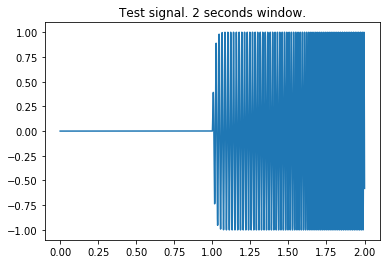

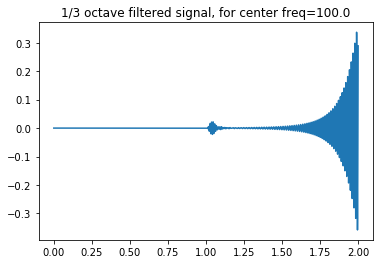

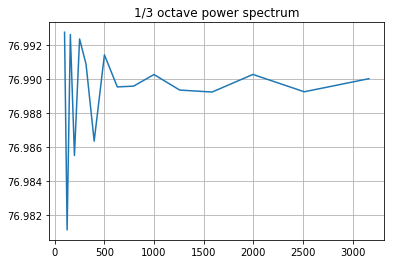

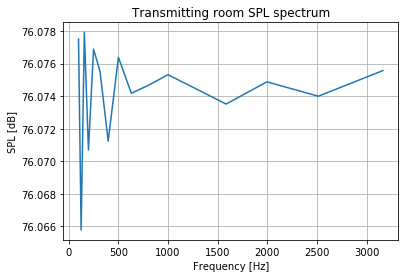

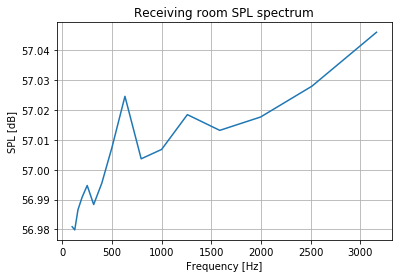

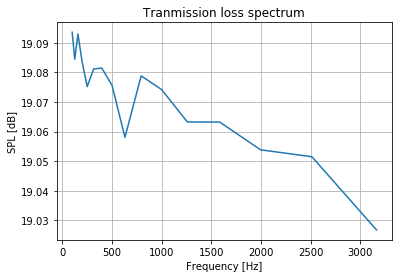

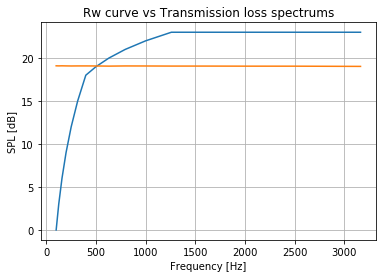

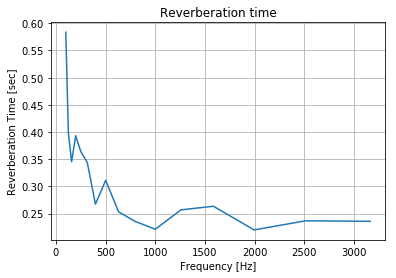

In [7]:
main()

In [2]:
gen = Generator()

In [11]:
signal, response = gen.noise('sine_sweep')
#

In [12]:
signal.size

441000

In [13]:
signal = signal[None, ...]
signal.size

441000

In [59]:
441000 - (26 * 16384)

15016

In [60]:
16384 * 27 - 441000

1368

In [55]:
import numpy as np
a = np.ones((1, 10))
a

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [47]:
a[a.size:]

array([], shape=(0L, 10L), dtype=float64)

In [58]:
(26 * 16384)

442368